In [16]:
import random
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [2]:
# Conectar a MongoDB
client = MongoClient("mongodb://localhost:27017/")
database = client["ETIB_TFM"]
collection = database["data_model"]

In [3]:
# Rango de fechas
start_date = datetime(2024, 11, 13)
end_date = datetime(2024, 11, 14)

# Obtener los datos de MongoDB
query = {"Fecha_Transaccion": {"$gte": start_date, "$lt": end_date}}
cursor = collection.find(query)

#Convertir los datos a un DataFrame de Pandas
df_pandas = pd.DataFrame(list(cursor))

# Mostrar las primeras filas del DataFrame
df_pandas.head()

,_id,Dispositivo,Emisor,Estacion_Parada,Fase,Fecha_Clearing,Fecha_Transaccion,Hora_Pico_SN,ID_Vehiculo,Linea,...,Valor,archivo,cenefa,Hora,Año,Mes,Día,Fecha,longitud_paradero,latitud_paradero
0,67472002f909cbe62008b415,220007277,(3101000) Bogota Card(Citizen),(51103) 016A04_TM|016A04_Centro Comercial Port...,Fase 3,2024-11-12,2024-11-13 00:00:02,Peak Time,107142,(1372) T21,...,0.0,Validacion_001_CONSORCIO EXPRESS USAQUEN_20241...,016A04,0,2024,11,13,2024-11-13,-74.111766,4.709791
1,6747203bf909cbe6201e4ba1,220000882,(3101000) Bogota Card(Citizen),(52334) 265A11_TM|265A11_Br. Vista Hermosa,Fase 3,2024-11-12,2024-11-13 00:01:15,Peak Time,207044,(1138) T11,...,0.0,Validacion_002_MASIVO CAPITAL SUBA ORIENTAL_20...,265A11,0,2024,11,13,2024-11-13,-74.149375,4.546931
2,67471e59f909cbe62002f212,220008865,(3200601) Itaú,(57309) 217A00_TM|217A00_Pq. P�blico La Reserva,Fase 3,2024-11-12,2024-11-13 00:02:43,Peak Time,157105,(1064) T13,...,2950.0,Validacion_011_CONSORCIO EXPRESS SAN CRISTOBAL...,217A00,0,2024,11,13,2024-11-13,-74.039616,4.678390
3,67471e5bf909cbe62004020f,220006839,(3101000) Bogota Card(Citizen),(53368) 058A12_TM|058A12_Br. Tenerife,Fase 3,2024-11-12,2024-11-13 00:07:27,Peak Time,937140,(10127) HA708,...,0.0,Validacion_018_GRAN AMERICAS USME_20241112.csv,058A12,0,2024,11,13,2024-11-13,-74.114731,4.505537
4,67472029f909cbe62017a440,220002863,(3101000) Bogota Card(Citizen),(51954) 486A09_TM|486A09_Br. Jos�ar�Carbonell,Fase 3,2024-11-12,2024-11-13 00:08:29,Peak Time,707065,(1025) 94,...,2950.0,Validacion_007_ETIB_20241112.csv,486A09,0,2024,11,13,2024-11-13,-74.197389,4.605388


In [4]:
# Clase que contiene las funcionalidades para la optimización de rutas
class TransportOptimization:
    def __init__(self, dataframe):
        # Almacena el DataFrame y el grafo vacío
        self.df = dataframe
        self.G = nx.DiGraph()

    def preprocess_data(self):
        """ Preprocesa el DataFrame eliminando duplicados y seleccionando una ruta por parada """
        # Elimina duplicados en base a las columnas relevantes
        self.df = self.df.drop_duplicates(subset=['Ruta', 'cenefa', 'latitud_paradero', 'longitud_paradero'])
        
        # Agrupa por ruta para obtener la ruta única
        self.df = self.df.groupby('Ruta').apply(lambda x: x.sort_values(by='Fecha_Transaccion')).reset_index(drop=True)
        
        # Seleccionamos solo las columnas necesarias
        self.df = self.df[['Ruta', 'cenefa', 'latitud_paradero', 'longitud_paradero']]
    
    def haversine(self, lat1, lon1, lat2, lon2):
        """Calcula la distancia entre dos puntos geográficos (lat1, lon1) y (lat2, lon2) usando la fórmula de Haversine."""
        R = 6371.0  # Radio de la Tierra en km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distance = R * c
        return distance
    
    def build_graph(self):
        """Construye el grafo dirigido con las paradas y las distancias calculadas como pesos en las aristas"""
        for ruta in self.df['Ruta'].unique():
            # Filtramos las paradas de esta ruta
            df_ruta = self.df[self.df['Ruta'] == ruta]
            
            # Iteramos sobre las paradas consecutivas para crear las aristas
            for i in range(len(df_ruta) - 1):
                parada_actual = df_ruta.iloc[i]
                parada_siguiente = df_ruta.iloc[i+1]
                
                # Calculamos la distancia entre las paradas consecutivas
                distancia = self.haversine(parada_actual['latitud_paradero'], parada_actual['longitud_paradero'],
                                           parada_siguiente['latitud_paradero'], parada_siguiente['longitud_paradero'])
                
                # Añadimos una arista en el grafo con el peso de la distancia
                self.G.add_edge(parada_actual['cenefa'], parada_siguiente['cenefa'], weight=distancia)
    
    def plot_graph(self, sample_size=None, layout='spring', decimal_places=2):
        """Dibuja el grafo utilizando NetworkX y Matplotlib con opciones para personalizar el diseño, tamaño y precisión"""
        
        # Si se proporciona un tamaño de muestra, tomamos una muestra aleatoria de paraderos
        if sample_size:
            sampled_nodes = np.random.choice(self.G.nodes, size=sample_size, replace=False)
            G_sample = self.G.subgraph(sampled_nodes)  # Creando un subgrafo con los nodos seleccionados
        else:
            G_sample = self.G
        
        # Elegir el layout del grafo
        if layout == 'spring':
            pos = nx.spring_layout(G_sample, seed=42)  # Diseño distribuido de nodos
        elif layout == 'kamada_kawai':
            pos = nx.kamada_kawai_layout(G_sample)  # Kamada-Kawai layout para distribución más uniforme
        elif layout == 'circular':
            pos = nx.circular_layout(G_sample)  # Diseño circular de los nodos
        else:
            pos = nx.spring_layout(G_sample, seed=42)  # Por defecto, usamos spring_layout
        
        # Dibujar el grafo
        plt.figure(figsize=(12, 8))  # Ajusta el tamaño del gráfico
        nx.draw(G_sample, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8, font_weight="bold", font_color='black')
        
        # Etiquetas de los pesos de las aristas (distancias), redondeando a los decimales especificados
        labels = nx.get_edge_attributes(G_sample, 'weight')
        rounded_labels = {k: round(v, decimal_places) for k, v in labels.items()}
        nx.draw_networkx_edge_labels(G_sample, pos, edge_labels=rounded_labels, font_size=7)
    
        # Mostrar el gráfico
        plt.title(f"Visualización del grafo - {layout} layout")
        plt.show()
    
    # Graficamos usando una muestra de paraderos, layout Kamada-Kawai y 2 decimales para las distancias
    #optimizer.plot_graph(sample_size=30, layout='kamada_kawai', decimal_places=2)

    def shortest_path(self, start, end):
        """Calcula la ruta más corta entre dos paradas usando la distancia como peso"""
        path = nx.shortest_path(self.G, source=start, target=end, weight='weight')
        distance = nx.shortest_path_length(self.G, source=start, target=end, weight='weight')
        return path, distance

C:\Users\Gabo0\AppData\Local\Temp\ipykernel_1708\2212795560.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df = self.df.groupby('Ruta').apply(lambda x: x.sort_values(by='Fecha_Transaccion')).reset_index(drop=True)


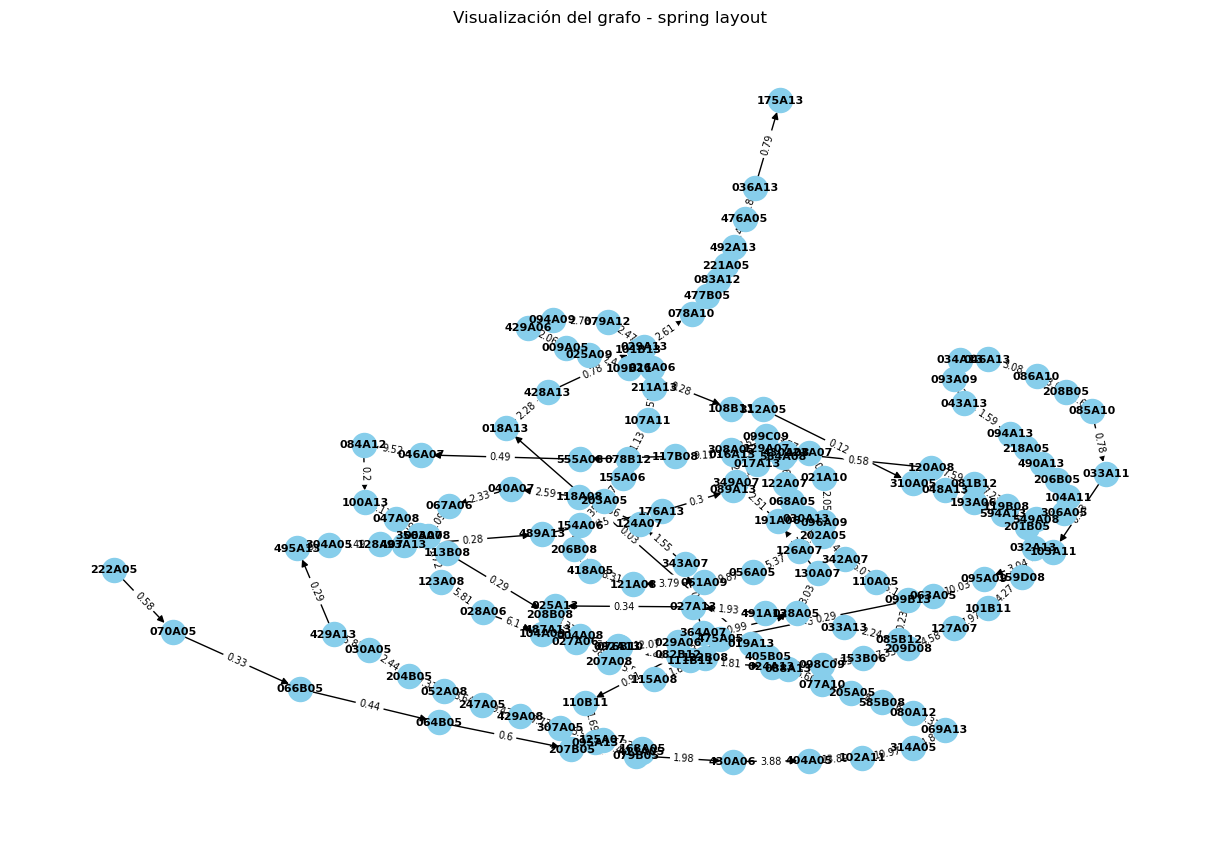

Ruta más corta de 222A05 a 111B11: ['222A05', '070A05', '066B05', '064B05', '207B05', '411A05', '168A05', '125A07', '307A05', '429A08', '247A05', '052A08', '204B05', '030A05', '429A13', '495A13', '304A05', '128A07', '493A13', '489A13', '176A13', '089A13', '017A13', '129A07', '584A08', '122A07', '068A05', '030A13', '202A05', '342A07', '110A05', '099B13', '085B12', '033A13', '491A13', '027A13', '025A13', '487A13', '027A06', '076B10', '111B11']
Distancia total: 222.56 km


In [10]:
# Creamos una instancia de la clase TransportOptimization
optimizer = TransportOptimization(df_pandas)

# Especificamos la ruta que queremos optimizar
ruta = "(4509) 740_20201013_V1"  # Ruta a optimizar
df_ruta = optimizer.df[optimizer.df['Ruta'] == ruta]

# Verificamos si la ruta tiene paraderos
if df_ruta.empty:
    print(f"No se encontraron paraderos para la ruta: {ruta}")
else:
    # Preprocesamos los datos (eliminamos duplicados y ordenamos las rutas)
    optimizer.df = df_ruta  # Filtramos el DataFrame para esta ruta
    optimizer.preprocess_data()

    # Construimos el grafo basado en las paradas filtradas de la ruta específica
    optimizer.build_graph()

    # Dibujamos el grafo para visualizarlo
    optimizer.plot_graph()

    # Obtener el primer y último paradero de la ruta (usando 'cenefa')
    start_parada = df_ruta['cenefa'].iloc[0]  # Primer paradero de la ruta
    end_parada = df_ruta['cenefa'].iloc[-1]   # Último paradero de la ruta

    # Calculamos la ruta más corta entre el primer y último paradero
    ruta_optima, distancia_total = optimizer.shortest_path(start_parada, end_parada)
    print(f"Ruta más corta de {start_parada} a {end_parada}: {ruta_optima}")
    print(f"Distancia total: {distancia_total:.2f} km")

In [ ]:
df_pandas['Ruta'].unique()

NameError: name 'route' is not defined

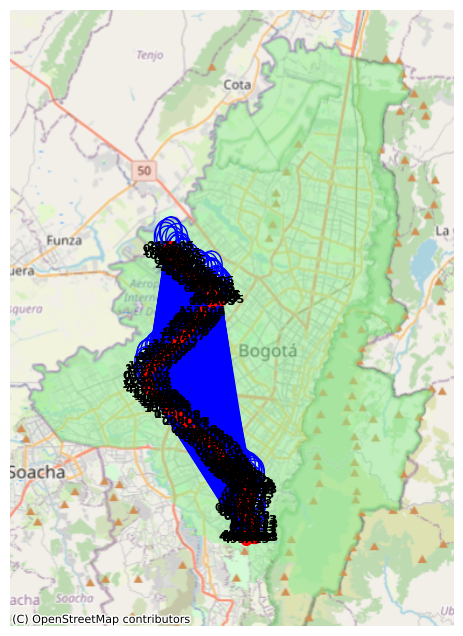

In [17]:
shapefile = gpd.read_file('../maps/Loca.shp')
shapefile
shapefile_filtered = shapefile[~shapefile['LocNombre'].isin(['USME', 'SUMAPAZ','CIUDAD BOLIVAR'])]
shapefile_filtered

# Cargar el shapefile de Bogotá
shapefile = shapefile_filtered

# Crear un grafo vacío
G = nx.Graph()

# Añadir nodos al grafo, cada nodo representa un paradero
for index, row in df_ruta.iterrows():
    G.add_node(row['cenefa'], pos=(row['longitud_paradero'], row['latitud_paradero']))

# Añadir las conexiones entre los paraderos en el orden de la ruta (asumimos que están en el orden correcto)
for i in range(len(df_ruta) - 1):
    start_parada = df_ruta.iloc[i]['cenefa']
    end_parada = df_ruta.iloc[i + 1]['cenefa']
    G.add_edge(start_parada, end_parada)

# Crear la figura y el eje para el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el mapa base de Bogotá
shapefile.plot(ax=ax, color='lightgreen', alpha=0.5)

# Agregar la capa base de OpenStreetMap
ctx.add_basemap(ax, crs=shapefile.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Extraer las coordenadas de los nodos
pos = nx.get_node_attributes(G, 'pos')

# Dibujar el grafo (paraderos como nodos y las conexiones entre ellos como aristas)
nx.draw(G, pos, ax=ax, with_labels=True, node_size=50, node_color='red', edge_color='blue', font_size=8, font_weight='bold')

# Añadir título y etiquetas
ax.set_title(f"Ruta con paraderos conectados: {route}", fontsize=14)
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

# Ajustar los límites del gráfico para mejorar la visualización
ax.set_xlim(df_ruta['longitud_paradero'].min() - 0.01, df_ruta['longitud_paradero'].max() + 0.01)
ax.set_ylim(df_ruta['latitud_paradero'].min() - 0.01, df_ruta['latitud_paradero'].max() + 0.01)

# Ajustar el espaciado para evitar recorte
plt.tight_layout()

# Guardar la imagen como archivo PNG
output_filename = f"../images/mapa_ruta_conectada_{route}.png"
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# Cerrar la figura después de mostrarla
plt.close(fig)